In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.stats import gaussian_kde

In [3]:
np.random.seed(1)

In [4]:
points_per_cluster = 100

means = 3.0 * np.array([0, 1, 2, 3])
sigma = 1.0  # data-generating standard deviation (assume known & fixed)
K = len(means)
labels = []
data = []

for k in range(K):
    for i in range(points_per_cluster):
        labels.append(k)
        x = np.random.normal(means[k], sigma)
        data.append(x)

data = np.array(data)
labels = np.array(labels)

indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [5]:
data.shape, labels.shape

((400,), (400,))

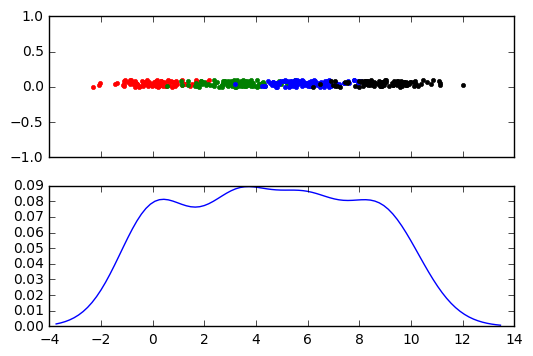

In [6]:
fig, ax = plt.subplots(2, 1, sharex=True)
colors = ['red', 'green', 'blue', 'black']
for k in range(K):
    mask = (labels == k)
    x = data[mask]
    y = np.random.uniform(0, 0.1, len(x))
    ax[0].plot(x, y, '.', color=colors[k])
ax[0].set_ylim(-1, 1)

# Use kernel density estimation
density = gaussian_kde(data)
a, b = np.min(data), np.max(data)

x = np.linspace(a - (b - a) * 0.1, b + (b - a) * 0.1, 100)
y = density.evaluate(x)
ax[1].plot(x, y)
ax[1].set_ylim(0, None)

None

In [7]:
def normalize_by_row(X):
    denom = X.sum(axis = 1, keepdims = True)
    result = np.true_divide(X, denom)
    return result

In [8]:
def variational_inference(data, K, prior_stdev, num_iters=1000):
    data = np.asarray(data)
    n = data.shape[0]

    m_history = []
    
    # Initialize variational parameters
    m = np.random.normal(0, prior_stdev, size=K)
    s2 = np.ones(K)
    phi = normalize_by_row(np.ones((n, K)))
    #phi = normalize_by_row(np.random.uniform(0, 1, (n, K)))

    m_history.append(m.copy())
    
    for iter_index in range(num_iters):
        for i in range(n):
            for k in range(K):
                phi[i, k] = np.exp(m[k] * data[i] - (m[k]**2 + s2[k]) / 2.0)
        phi = normalize_by_row(phi)
        for k in range(K):
            denom = 1 / float(prior_stdev) ** 2 + np.sum(phi[:, k])
            m[k] = np.inner(phi[:, k], data) / denom
            s2[k] = 1 / denom
        m_history.append(m.copy())

    return m, s2, phi, np.array(m_history)

In [9]:
%%time
m, s2, phi, m_history = variational_inference(data, K, prior_stdev=sigma)

CPU times: user 2.78 s, sys: 14.6 ms, total: 2.8 s
Wall time: 2.81 s


In [10]:
print ["{:.3f}".format(mi) for mi in m]

['5.757', '8.843', '0.086', '3.110']


In [11]:
means

array([ 0.,  3.,  6.,  9.])

In [12]:
corrected_permutation = np.array([np.argmin(np.abs(m[i] - means)) for i in range(len(m))])
corrected_permutation

array([2, 3, 0, 1])

In [13]:
inv_corrected_permutation = np.zeros(K, dtype='int')
inv_corrected_permutation[corrected_permutation] = np.arange(K)
inv_corrected_permutation

array([2, 3, 0, 1])

In [14]:
pred_labels = np.argmax(phi, axis=1)

In [15]:
confusion_matrix = np.zeros((K, K))
for i in range(len(labels)):
    #confusion_matrix[labels[i], corrected_permutation[pred_labels[i]]] += 1
    confusion_matrix[labels[i], pred_labels[i]] += 1

    confusion_matrix

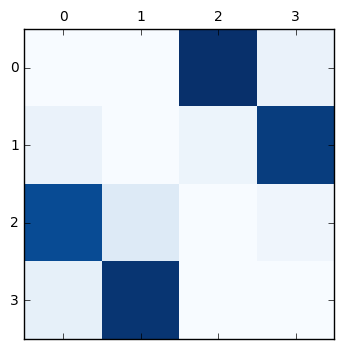

In [16]:
plt.matshow(confusion_matrix, cmap='Blues', vmin=0, vmax=np.max(confusion_matrix))
None

In [17]:
from matplotlib.patches import Rectangle

In [18]:
def display_cluster_results(data, labels, m, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    colors = ['red', 'green', 'blue', 'black']
    for k in range(K):
        mask = (labels == k)
        x = data[mask]
        #y = np.random.uniform(0, 0.1, len(x))
        y = 0.1 * np.arange(len(x)) / float(len(x))
        ax.plot(x, y, '.', color=colors[k])

        #ax.axvspan(m[k] - 1, m[k] + 1, color=colors[k], alpha=0.2)
        ax.add_patch(Rectangle((m[k] - sigma, 1-0.5 * (k+1) / float(K)), 2*sigma, 0.5/float(K), color=colors[k]))
    ax.set_ylim(-1, 1)

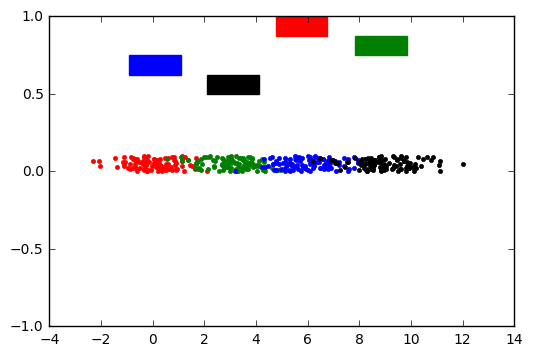

In [23]:
display_cluster_results(data, labels, m)

In [20]:
from matplotlib.animation import FuncAnimation

In [21]:
fig, ax = plt.subplots()
def update(i):
    ax.clear()
    display_cluster_results(data, labels, m_history[i], ax)
#frames = np.linspace(0, len(m_history)-1, 20).astype('int')
frames = np.arange(30)
anim = FuncAnimation(fig, func=update, frames=frames, interval=100)
plt.close()

In [24]:
from IPython.display import HTML

In [25]:
HTML(anim.to_html5_video())